# Main

In [ ]:
!pip install tqdm

In [ ]:

import numpy as np
import cv2
from math import exp, pi, sqrt
from numba import vectorize
import sys
from PIL import Image
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from tqdm import tqdm

class MFR:

    def __init__(self, L, sigma, w, c):
        self.L = max(L, 1)
        self.sigma = max(sigma, 1)
        self.w = max(w, 1)
        self.c = c


    def _filter_kernel_mf_fdog(self, t=3, mf=True):
        # Ensure dimensions are valid
        dim_x = max(int(2 * t * self.sigma), 1)
        dim_y = max(int(self.L), 1)

        # Create an array to hold the kernel values
        arr = np.zeros((dim_y, dim_x), dtype='float32')

        # Calculate the center of the kernel
        ctr_x = dim_x / 2

        # Populate the array with x-coordinates relative to the center
        for y in range(dim_y):
            arr[y, :] = np.arange(dim_x) - ctr_x

        # Compute shared variables for Gaussian and FDOG
        two_sigma_sq = max(2 * self.sigma ** 2, 1)
        normalization_factor = 1 / max(sqrt(2 * pi) * self.sigma, 1)

        # Adjust the normalization factor for FDOG
        if not mf:
            normalization_factor /= max(self.sigma ** 2, 1)

        # Generate the kernel using vectorized operations
        if mf:
            kernel = normalization_factor * np.exp(-arr ** 2 / two_sigma_sq)
            kernel -= np.mean(kernel)  # Adjust for Gaussian kernel
        else:
            kernel = -arr * normalization_factor * np.exp(-arr ** 2 / two_sigma_sq)

        return kernel





    def fdog_filter_kernel(self, t = 3):
        '''
        K = - (x/(sqrt(2 * pi) * sigma ^3)) * exp(-x^2/2sigma^2), |y| <= L/2, |x| < s * t
        '''
        return self._filter_kernel_mf_fdog(t, False)

    def gaussian_matched_filter_kernel(self, t = 3):
        '''
        K =  1/(sqrt(2 * pi) * sigma ) * exp(-x^2/2sigma^2), |y| <= L/2, |x| < s * t
        '''
        return self._filter_kernel_mf_fdog(t, True)

    def createMatchedFilterBank(self, K, n=12):

        rotation_interval = 180 / n
        kernel_center = (K.shape[1] // 2, K.shape[0] // 2)
        rotated_kernels = [K]

        for i in range(1, n):
            rotation_angle = i * rotation_interval
            rotation_matrix = cv2.getRotationMatrix2D(kernel_center, rotation_angle, 1)
            rotated_kernel = cv2.warpAffine(K, rotation_matrix, K.shape[::-1])

            # Subtract the mean from non-zero elements only
            nonzero_elements = rotated_kernel != 0
            if nonzero_elements.any():
                mean_value = np.mean(rotated_kernel[nonzero_elements])
                rotated_kernel[nonzero_elements] -= mean_value

            rotated_kernels.append(rotated_kernel)

        return rotated_kernels


    def applyFilters(self, image, filter_bank):

        filtered_images = [cv2.filter2D(image, -1, kernel) for kernel in filter_bank]
        max_response = np.max(filtered_images, axis=0)
        return max_response

def is_coordinate_within_bounds(image_shape: tuple, coordinate: tuple) -> bool:
    assert len(image_shape) == len(coordinate), "Dimension mismatch between image shape and coordinate."

    for dimension_size, coord in zip(image_shape, coordinate):
        if coord < 0 or coord >= dimension_size:
            return False

    return True


def label_connected_region(src_img, label_img, x, y, label_id, region_size, max_size=500):
    if not src_img[y, x] or label_img[y, x] or region_size > max_size:
        return False

    label_img[y, x] = label_id
    region_size += 1

    # Directions for 8-connected neighbors (up, down, left, right, and diagonals)
    directions = [(1, 0), (0, 1), (-1, 0), (0, -1), (1, 1), (1, -1), (-1, 1), (-1, -1)]

    for dx, dy in directions:
        new_x, new_y = x + dx, y + dy
        if is_coordinate_within_bounds(src_img.shape, (new_y, new_x)):
            label_connected_region(src_img, label_img, new_x, new_y, label_id, region_size, max_size)

    return True

def load_and_preprocess_image(image_path, mask_path):

    # Load the original image and mask using PIL
    original_image = Image.open(image_path)
    mask = Image.open(mask_path).convert('L')  # Convert mask to grayscale

    # Convert PIL images to NumPy arrays for OpenCV processing
    original_image_np = np.array(original_image)
    mask_np = np.array(mask)

    # Extract the green channel from the original image
    _, green_channel, _ = cv2.split(original_image_np)

    # Invert the green channel
    inverted_green_channel = 255 - green_channel

    # Get the dimensions of the image
    image_height, image_width = inverted_green_channel.shape[:2]

    return original_image, mask, mask_np, inverted_green_channel, image_height, image_width



def generator(image_path, mask_path, L, sigma, w, c):

    # Load and preprocess the image
    original_image, mask, mask_np, green_channel, height, width = load_and_preprocess_image(image_path, mask_path)

    # Initialize MFR class
    mfr = MFR(L, sigma, w, c)

    # Generate Gaussian filter and FDOG filter
    gaussian_filter = mfr.gaussian_matched_filter_kernel()
    fdog_filter = mfr.fdog_filter_kernel()

    # Generate filter banks
    gaussian_filter_bank = mfr.createMatchedFilterBank(gaussian_filter, 12)
    fdog_filter_bank = mfr.createMatchedFilterBank(fdog_filter, 12)

    # Apply filters to get matched filter responses
    gaussian_response = mfr.applyFilters(green_channel, gaussian_filter_bank)
    fdog_response = mfr.applyFilters(green_channel, fdog_filter_bank)

    # Threshold calculation using FDOG response
    smoothing_kernel = np.ones((31, 31), np.float32) / (31 * 31)
    normalized_fdog = cv2.filter2D(np.array(fdog_response, dtype='f'), -1, smoothing_kernel)
    normalized_fdog = cv2.normalize(normalized_fdog, 0, 1, cv2.NORM_MINMAX)
    threshold_value = (1 + normalized_fdog) * (mfr.c * cv2.mean(gaussian_response)[0])

    # Apply threshold to Gaussian response
    processed_image = np.zeros(gaussian_response.shape)
    processed_image[gaussian_response > threshold_value] = 255

    ############## LAPLACIAN



    # Mask processing to focus on the region of interest
    laplacian = cv2.Laplacian(mask_np, cv2.CV_64F)
    laplacian = cv2.dilate(laplacian, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7)), iterations=4)
    processed_image[(mask_np == 0) | (laplacian != 0)] = 0


    ###################### CANNY

    # canny_edges = cv2.Canny(mask_np, 50, 150)  # Adjust thresholds as needed
    # # Dilation as a post-processing step to remove edges
    # kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))  # Adjust kernel size as needed
    # dilated_canny_edges = cv2.dilate(canny_edges, kernel, iterations=1)
    # processed_image[dilated_canny_edges != 0] = 0

    # ##################### Hough
    # # Apply Hough Circle Transform to find the circular boundary of the retina
    # circles = cv2.HoughCircles(mask_np, cv2.HOUGH_GRADIENT, 1, minDist=200,
    #                            param1=50, param2=30, minRadius=0, maxRadius=0)

    # # If at least one circle is detected, use the first one as the main boundary
    # if circles is not None:
    #     circles = np.uint16(np.around(circles))
    #     main_circle = circles[0, 0]  # Taking the first detected circle
    #     center_x, center_y, radius = main_circle[0], main_circle[1], main_circle[2]

    #     # Create a mask with the detected circle
    #     circle_mask = np.zeros((height, width), np.uint8)
    #     cv2.circle(circle_mask, (center_x, center_y), radius, 255, thickness=-1)

    #     # Use the circle mask to keep the region of interest
    #     processed_image[circle_mask == 0] = 0







    # Removing small segments
    label_id = 1
    label_matrix = np.zeros(processed_image.shape)
    for y in range(height):
        for x in range(width):
            if not label_matrix[y, x] and processed_image[y, x]:
                label_connected_region(processed_image, label_matrix, x, y, label_id, 0)
                label_id += 1

    # Filter out segments smaller than a certain size
    segment_sizes = [np.sum(label_matrix == label) for label in range(1, label_id)]
    for label, size in enumerate(segment_sizes, start=1):
        if size <= 10:
            processed_image[label_matrix == label] = 0

    return gaussian_response, processed_image


In [ ]:
from glob import glob

img_dir = sorted(glob("/content/drive/MyDrive/DRIVE(processed)/images/*.tif"))
msk_dir = sorted(glob("/content/drive/MyDrive/DRIVE(processed)/masks/*.gif"))
GT_dir = sorted(glob("/content/drive/MyDrive/DRIVE(processed)/1st_manual/*.gif"))


# img_dir = img_dir[20:]
# msk_dir = msk_dir[20:]
# GT_dir = GT_dir[20:]


print(len(img_dir))
print(len(msk_dir))
print(len(GT_dir))

40
40
40


In [ ]:
img_dir

['/content/drive/MyDrive/DRIVE(processed)/images/01_test.tif',
 '/content/drive/MyDrive/DRIVE(processed)/images/02_test.tif',
 '/content/drive/MyDrive/DRIVE(processed)/images/03_test.tif',
 '/content/drive/MyDrive/DRIVE(processed)/images/04_test.tif',
 '/content/drive/MyDrive/DRIVE(processed)/images/05_test.tif',
 '/content/drive/MyDrive/DRIVE(processed)/images/06_test.tif',
 '/content/drive/MyDrive/DRIVE(processed)/images/07_test.tif',
 '/content/drive/MyDrive/DRIVE(processed)/images/08_test.tif',
 '/content/drive/MyDrive/DRIVE(processed)/images/09_test.tif',
 '/content/drive/MyDrive/DRIVE(processed)/images/10_test.tif',
 '/content/drive/MyDrive/DRIVE(processed)/images/11_test.tif',
 '/content/drive/MyDrive/DRIVE(processed)/images/12_test.tif',
 '/content/drive/MyDrive/DRIVE(processed)/images/13_test.tif',
 '/content/drive/MyDrive/DRIVE(processed)/images/14_test.tif',
 '/content/drive/MyDrive/DRIVE(processed)/images/15_test.tif',
 '/content/drive/MyDrive/DRIVE(processed)/images/16_tes

In [ ]:
L, sigma, w, c = 9, 1.5, 31, 2.3
L1, sigma1, w1, c1 = 5, 1, 31, 2.3


combinded = []
for i in range(len(img_dir)):
  _, out =  generator(img_dir[i], msk_dir[i], L, sigma, w, c)
  _, out1 = generator(img_dir[i], msk_dir[i], L1, sigma1, w1, c1)
  combined_imageee = np.logical_or(out, out1)
  combinded.append(combined_imageee)


In [ ]:
_, out =  generator(img_dir[8], msk_dir[8], L, sigma, w, c)
_, out1 = generator(img_dir[8], msk_dir[8], L1, sigma1, w1, c1)


In [ ]:
GTed = []
for i in range (len(GT_dir)):
  GTed.append(plt.imread(GT_dir[i]))

In [ ]:
print(len(combinded))
print(len(GTed))

40
40


In [ ]:
print(np.unique(combinded[0]))
print(np.unique(GTed[0]))

[False  True]
[  0 255]


In [ ]:
combinded = [img * 255 for img in combinded]


In [ ]:
print(np.unique(combinded))
print(np.unique(GTed))

[  0 255]
[  0 255]


In [ ]:
print(combinded[0].dtype)
print(GTed[0].dtype)

int64
uint8


In [ ]:

GTed = [img.astype(np.int64) for img in GTed]

In [ ]:
print(combinded[0].dtype)
print(GTed[0].dtype)

int64
int64


In [ ]:
def calculate_metrics(combined_image, gt_image):
    # Ensure the images are in binary format (0 and 255)
    combined_image = (combined_image > 0).astype(int) * 255
    gt_image = (gt_image > 0).astype(int) * 255

    # Calculate TP, FP, TN, FN
    TP = np.sum((combined_image == 255) & (gt_image == 255))
    FP = np.sum((combined_image == 255) & (gt_image == 0))
    TN = np.sum((combined_image == 0) & (gt_image == 0))
    FN = np.sum((combined_image == 0) & (gt_image == 255))

    # Calculate accuracy
    accuracy = (TP + TN) / (TP + FP + TN + FN) if (TP + FP + TN + FN) > 0 else 0

    # Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
    TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
    FPR = FP / (FP + TN) if (FP + TN) > 0 else 0

    return TPR, FPR, accuracy

# Example usage for one image pair:
TPR, FPR, accuracy = calculate_metrics(combinded[0], GTed[0])
print(f"TPR: {TPR}, FPR: {FPR}, Accuracy: {accuracy}")

TPR: 0.6837296195652174, FPR: 0.01848795421269799, Accuracy: 0.9549430233967754


In [ ]:
TPs = []
FPs = []
accuracys= []

for i in range(len(combinded)):
  TPR, FPR, accuracy = calculate_metrics(combinded[i], GTed[i])
  TPs.append(TPR)
  FPs.append(FPR)
  accuracys.append(accuracy)

In [ ]:
print(len(TPs))
print(len(FPs))
print(len(accuracys))
print(TPs)
print(FPs)
print(accuracys)

40
40
40
[0.6837296195652174, 0.6496004735128736, 0.5870853981090202, 0.6157672794359886, 0.604587215320911, 0.5386411757379499, 0.5954165561156806, 0.5099510373736307, 0.5324034254515538, 0.6567241125349831, 0.6415924709705813, 0.6235521235521235, 0.5877739545553179, 0.6461746073396559, 0.7088591513508935, 0.6078345809136988, 0.51723395088324, 0.6094706242350061, 0.7391034306382668, 0.6550175149392129, 0.6389407088977208, 0.6329631990338488, 0.5926897758136538, 0.5350388448559994, 0.4930057785215826, 0.579044717658579, 0.6131118219653975, 0.6078254933598114, 0.6565529170119996, 0.5797017462525113, 0.6006633832545984, 0.6030240142306552, 0.6052611856404106, 0.5801096416514386, 0.7101216272892492, 0.607624568052614, 0.6677299677542388, 0.6090529199002704, 0.6120713983349796, 0.7012919483220671]
[0.01848795421269799, 0.016027956916635715, 0.016046885046134374, 0.01571730873213487, 0.013175142452047832, 0.008420515437611636, 0.02085334614153058, 0.02233968120276817, 0.00996309598013317, 0

In [ ]:
TPss = sum(TPs) / len(TPs)
print(TPss)

0.6134086090084357


In [ ]:
FPss = sum(FPs) / len(FPs)
print(FPss)

0.018679994678891795


In [ ]:
accs = sum(accuracys) / len(accuracys)
print(accs)

0.9491393653776218


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc

def plot_roc_curve(TPs, FPs):
    # Combine TPs and FPs into a list of tuples and sort by FPR
    TPs_FPs = sorted(zip(TPs, FPs), key=lambda x: x[1])

    # Separate TPs and FPs after sorting
    sorted_TPs = [tp for tp, fp in TPs_FPs]
    sorted_FPs = [fp for tp, fp in TPs_FPs]

    # Filter out data points where FPR >= 0.05
    filtered_TPs = [tp for tp, fp in zip(sorted_TPs, sorted_FPs) if fp < 0.05]
    filtered_FPs = [fp for fp in sorted_FPs if fp < 0.05]

    # Add (0,0) and (1,1) to make the curve start at (0,0) and end at (1,1)
    filtered_TPs = [0] + filtered_TPs + [1]
    filtered_FPs = [0] + filtered_FPs + [1]

    # Calculate the AUC (Area Under Curve)
    roc_auc = auc(filtered_FPs, filtered_TPs)

    # Plot ROC curve
    plt.figure()
    plt.plot(filtered_FPs, filtered_TPs, color='blue', lw=0.5, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.xlim([0.0, 0.04])  # Setting x limit to 0.05 for FPR
    plt.ylim([0.0, 0.8])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

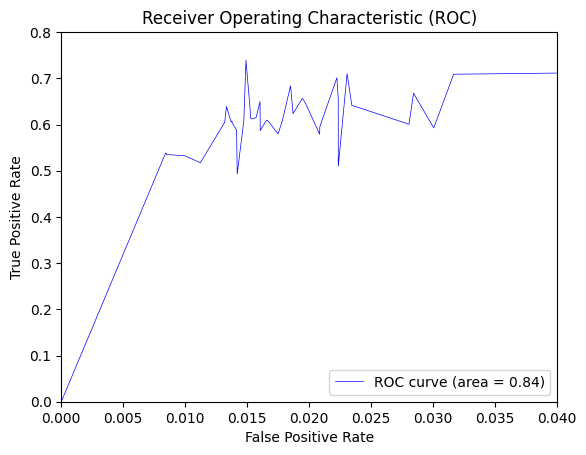

In [ ]:
plot_roc_curve(TPs, FPs)

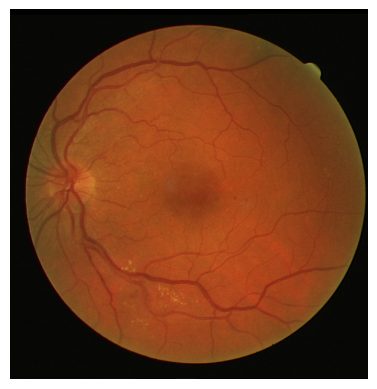

In [ ]:
import matplotlib.pyplot as plt

# Load and display the image without the axis
plt.imshow(plt.imread(img_dir[2]))
plt.axis('off')  # Turn off the axis
plt.show()


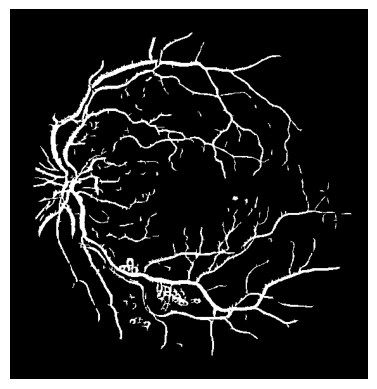

In [ ]:
import matplotlib.pyplot as plt

# Load and display the image without the axis
plt.imshow(combinded[2], "gray")
plt.axis('off')  # Turn off the axis
plt.show()

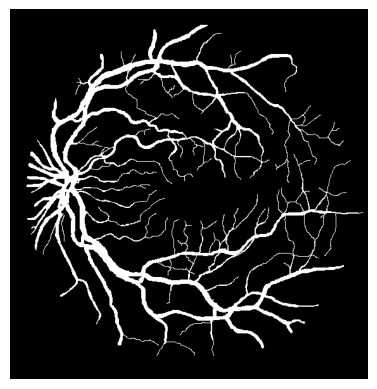

In [ ]:
import matplotlib.pyplot as plt

# Load and display the image without the axis
plt.imshow(GTed[2], "gray")
plt.axis('off')  # Turn off the axis
plt.show()


In [ ]:
#  plt.figure(figsize=(25, 25))

# plt.subplot(1, 4, 1)
# plt.imshow(out[0])
# plt.title('out')
# plt.axis('off')

# plt.subplot(1, 4, 2)
# plt.imshow(out1[0])
# plt.title('out 1')
# plt.axis('off')

# plt.subplot(1, 4, 3)
# plt.imshow(combined_imageee[0])
# plt.title('combined_imageee')
# plt.axis('off')

# plt.subplot(1, 4, 4)
# plt.imshow(GT[0])
# plt.title('GT')
# plt.axis('off')


# plt.show()

##############################
##############################
##############################
# print(np.unique(out))
# print(np.unique(out1))
# print(np.unique(combined_imageee))
# combined_imageee = combined_imageee * 255
# print(np.unique(combined_imageee))
# GT = GT.astype(np.int64)

##############################
##############################
##############################
##############################
##############################
##############################
# print(GT.dtype)
# print(combined_imageee.dtype)
##############################
##############################
##############################
##############################
##############################
############################################################
##############################
##############################
##############################
##############################
##############################

# def calculate_metrics(combined_image, gt_image):
#     # Ensure the images are in binary format (0 and 255)
#     combined_image = (combined_image > 0).astype(int) * 255
#     gt_image = (gt_image > 0).astype(int) * 255

#     # Calculate TP, FP, TN, FN
#     TP = np.sum((combined_image == 255) & (gt_image == 255))
#     FP = np.sum((combined_image == 255) & (gt_image == 0))
#     TN = np.sum((combined_image == 0) & (gt_image == 0))
#     FN = np.sum((combined_image == 0) & (gt_image == 255))

#     # Calculate accuracy
#     accuracy = (TP + TN) / (TP + FP + TN + FN)

#     return TP, FP, accuracy

# # Assuming combined_imageee and GT are your images
# TP, FP, accuracy = calculate_metrics(combined_imageee, GT)
# print(f"TP: {TP}, FP: {FP}, Accuracy: {accuracy}")



##############################
############################################################
##############################
##############################
##############################


        # Display the output image using matplotlib for better compatibility in various environments
        # plt.figure(figsize=(5, 5))
        # plt.imshow(out, cmap='gray')
        # plt.title(f'Output Image (L={L}, Sigma={sigma})')
        # plt.axis('off')
        # plt.show()

#############################
#############################
#############################
#############################
#############################



# tprs =  []
# fprs = []
# for c in combindes:
#   keke = c * 255
#   tpr, fpr = calculate_tpr_fpr(keke, GT)
#   tprs.append(tpr)
#   fprs.append(fpr)
#   print(f"TPR: {tpr}, FPR: {fpr}")